In [504]:
import numpy as np
from datetime import datetime
import pandas as pd
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import ffn
import warnings
warnings.filterwarnings('ignore')

In [505]:
from sklearn.linear_model import LinearRegression

In [506]:
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import yfinance as yf
pdr.get_data_yahoo = pdr.get_data_yahoo

In [507]:
start = datetime(2022, 1, 1)
end = datetime(2025, 1, 1)

bank_tickers = ['SBIN.NS', 'KOTAKBANK.NS', 'INDUSINDBK.NS', 'HDFCBANK.NS', 'ICICIBANK.NS', 'BANKBARODA.NS', 'CANBK.NS', 'AXISBANK.NS']


df = yf.download(bank_tickers, start, end)['Close']
df.tail()

[*********************100%***********************]  8 of 8 completed


Ticker,AXISBANK.NS,BANKBARODA.NS,CANBK.NS,HDFCBANK.NS,ICICIBANK.NS,INDUSINDBK.NS,KOTAKBANK.NS,SBIN.NS
Date,,,,,,,,
2024-12-24,1078.900024,244.949997,100.550003,1798.099976,1297.250000,935.299988,1749.050049,812.049988
2024-12-26,1076.699951,246.679993,101.029999,1790.750000,1297.349976,931.950012,1752.800049,812.450012
2024-12-27,1077.449951,244.990005,100.360001,1798.250000,1307.550049,953.400024,1759.900024,799.650024
2024-12-30,1069.949951,241.000000,99.440002,1777.900024,1294.650024,963.500000,1740.699951,788.299988
2024-12-31,1064.699951,240.550003,100.120003,1772.849976,1281.650024,960.150024,1786.050049,794.950012


In [508]:
df.index = pd.to_datetime(df.index)

In [509]:
df.loc["2022-01-01" : "2023-01-01"].to_csv('bank_train.csv')

In [510]:
df.loc["2023-01-01" : "2025-01-01"].to_csv('bank_test.csv')

In [511]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [512]:
df_train = pd.read_csv('bank_train.csv', index_col='Date',parse_dates=True)


In [513]:
res = coint_johansen(df_train[bank_tickers], det_order = 1, k_ar_diff = 1)

In [514]:
res.lr1

array([173.34326955, 118.69213613,  82.3005562 ,  54.45114642,
        33.62452429,  19.79995059,   9.04371417,   0.46155552])

In [515]:
res.cvt

array([[169.0618, 175.1584, 187.1891],
       [133.7852, 139.278 , 150.0778],
       [102.4674, 107.3429, 116.9829],
       [ 75.1027,  79.3422,  87.7748],
       [ 51.6492,  55.2459,  62.5202],
       [ 32.0645,  35.0116,  41.0815],
       [ 16.1619,  18.3985,  23.1485],
       [  2.7055,   3.8415,   6.6349]])

In [516]:
res.lr2

array([54.65113342, 36.39157993, 27.84940978, 20.82662213, 13.8245737 ,
       10.75623642,  8.58215865,  0.46155552])

In [517]:
res.cvm

array([[52.5858, 55.7302, 62.1741],
       [46.5583, 49.5875, 55.8171],
       [40.5244, 43.4183, 49.4095],
       [34.4202, 37.1646, 42.8612],
       [28.2398, 30.8151, 36.193 ],
       [21.8731, 24.2522, 29.2631],
       [15.0006, 17.1481, 21.7465],
       [ 2.7055,  3.8415,  6.6349]])

In [518]:
arb_vec = res.evec[0]

<Axes: xlabel='Date'>

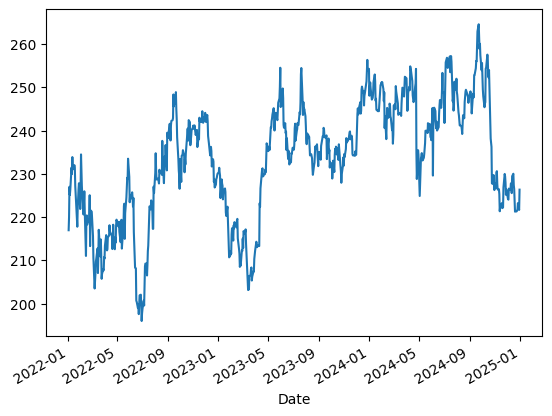

In [519]:
(df[bank_tickers] @ arb_vec).plot()

In [520]:
df_test = pd.read_csv('bank_test.csv', index_col='Date',parse_dates=True)

In [521]:
import ffn

In [522]:
def backtest(stock_price_df, coeffs, entryZscore, exitZscore):
    stock_names = stock_price_df.keys()
    df = stock_price_df.copy()
    df['spread'] = df[stock_names] @ coeffs
    df['mean_30'] = df['spread'].rolling(window = 30).mean()
    df['std_30'] = df['spread'].rolling(window = 30).std()
    df['z_score'] = (df['spread'] - df['mean_30'])/df['std_30']

    df['long_entry'] = (df.z_score < - entryZscore) & (df.z_score.shift(1) > - entryZscore)
    df['long_exit'] = (df.z_score > - exitZscore) & ( df.z_score.shift(1) < - exitZscore)
    df['num_units_long'] = np.nan
    df.loc[df['long_entry'], 'num_units_long'] = 1
    df.loc[df['long_exit'], 'num_units_long'] = 0
    df['num_units_long'][0] = 0
    df['num_units_long'] = df['num_units_long'].fillna(method='pad')

    df['short_entry'] = (df.z_score > entryZscore) & ( df.z_score.shift(1) < entryZscore)
    df['short_exit'] = (df.z_score < exitZscore) & ( df.z_score.shift(1) > exitZscore)
    df['num_units_short'] = np.nan
    df.loc[df['short_entry'], 'num_units_short'] = -1
    df.loc[df['short_exit'], 'num_units_short'] = 0
    df['num_units_short'][0] = 0
    df['num_units_short'] = df['num_units_short'].fillna(method='pad')

    df['numUnits'] = df['num_units_short'] + df['num_units_short']
    df['spread_pct_chg'] = df.spread.diff()/df.spread
    df['port rets'] = df['spread_pct_chg'] * df['numUnits'].shift(1)

    df['cum rets'] = df['port rets'].cumsum()
    df['cum rets'] = df['cum rets'] + 1

    try:
        sharpe = ((df['port rets'].mean() / df['port rets'].std()) * (252) ** 0.5)
    except ZeroDivisionError:
        sharpe = 0.0

    return df['cum rets'], sharpe

In [523]:
from pykalman import KalmanFilter

In [524]:
def KF_Avg(x):
    """Smoothens a stock price series, removing all possible noise"""
    kf = KalmanFilter(transition_matrices = [1], ## System Model: priori_price_on_next_day = price_on_last_day
                      observation_matrices = [1], ## Measuring stock price on the next day
                      initial_state_mean = 0,
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.01)
    state_means, state_covs = kf.filter(x.values) ## x is assumed to be sequential measurements of the stock price
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

In [525]:
def backtest_KF(stock_price_df, coeffs, entryZscore, exitZscore):
    stock_names = stock_price_df.keys()
    df = stock_price_df.copy()
    for s in stock_names:
        df[s] = KF_Avg(df[s])
    df['spread'] = df[stock_names] @ coeffs
    df['mean_30'] = df['spread'].rolling(window = 30).mean()
    df['std_30'] = df['spread'].rolling(window = 30).std()
    df['z_score'] = (df['spread'] - df['mean_30'])/df['std_30']

    df['long_entry'] = (df.z_score < - entryZscore) & (df.z_score.shift(1) > - entryZscore)
    df['long_exit'] = (df.z_score > - exitZscore) & ( df.z_score.shift(1) < - exitZscore)
    df['num_units_long'] = np.nan
    df.loc[df['long_entry'], 'num_units_long'] = 1
    df.loc[df['long_exit'], 'num_units_long'] = 0
    df['num_units_long'][0] = 0
    df['num_units_long'] = df['num_units_long'].fillna(method='pad')

    df['short_entry'] = (df.z_score > entryZscore) & ( df.z_score.shift(1) < entryZscore)
    df['short_exit'] = (df.z_score < exitZscore) & ( df.z_score.shift(1) > exitZscore)
    df['num_units_short'] = np.nan
    df.loc[df['short_entry'], 'num_units_short'] = -1
    df.loc[df['short_exit'], 'num_units_short'] = 0
    df['num_units_short'][0] = 0
    df['num_units_short'] = df['num_units_short'].fillna(method='pad')

    df['numUnits'] = df['num_units_short'] + df['num_units_short']
    df['spread_pct_chg'] = df.spread.diff()/df.spread
    df['port rets'] = df['spread_pct_chg'] * df['numUnits'].shift(1)

    df['cum rets'] = df['port rets'].cumsum()
    df['cum rets'] = df['cum rets'] + 1

    try:
        sharpe = ((df['port rets'].mean() / df['port rets'].std()) * (252) ** 0.5)
    except ZeroDivisionError:
        sharpe = 0.0

    return df['cum rets'], sharpe

In [526]:
backtest_KF(df_test[bank_tickers], arb_vec, 2, 0)

(Date
 2023-01-02         NaN
 2023-01-03    1.000000
 2023-01-04    1.000000
 2023-01-05    1.000000
 2023-01-06    1.000000
                 ...   
 2024-12-24    0.637041
 2024-12-26    0.637041
 2024-12-27    0.637041
 2024-12-30    0.637041
 2024-12-31    0.637041
 Name: cum rets, Length: 491, dtype: float64,
 -3.9797706386055283)

In [527]:
for bk in bank_tickers:
    df_train[f"{bk}_smooth"] = KF_Avg(df_train[bk])
    df_test[f"{bk}_smooth"] = KF_Avg(df_test[bk])

<Axes: xlabel='Date'>

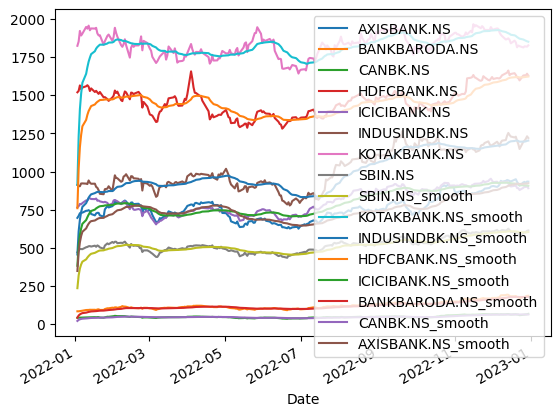

In [528]:
# df_train[bank_tickers].plot()
df_train[df_train.keys()].plot()
# df_train[[f"{bk}_smooth" for bk in bank_tickers].extend(bank_tickers)].plot()

In [529]:
bank_tickers_smooth = [f"{bk}_smooth" for bk in bank_tickers]

In [531]:
ret, sharpe = backtest(df[bank_tickers], arb_vec, 1, 0)

start                    2022-01-03 00:00:00
end                      2024-12-31 00:00:00
rf                                       0.0
total_return                             NaN
cagr                                0.147864
max_drawdown                       -0.372096
calmar                               0.39738
mtd                                 0.032051
three_month                         0.058096
six_month                           0.126085
ytd                                 0.683319
one_year                            0.683319
three_year                          0.147864
five_year                                NaN
ten_year                                 NaN
incep                               0.147864
daily_sharpe                        0.665477
daily_sortino                       1.166951
daily_mean                           0.17485
daily_vol                           0.262744
daily_skew                          1.852602
daily_kurt                          18.67662
best_day  

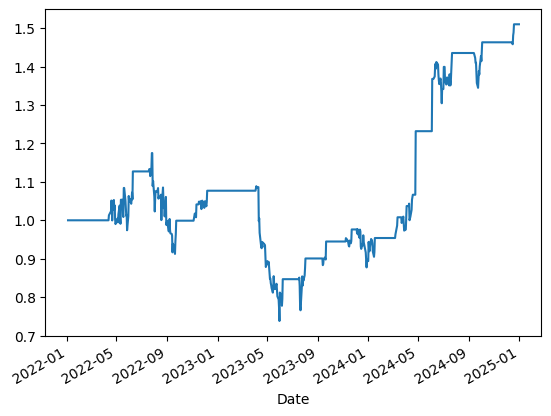

In [532]:
ret.plot()
ret.calc_stats().stats